<a href="https://colab.research.google.com/github/Zee05/JSE-Stock-Market-Returns-Prediction-Using-Multivariate-Time-Series-Data/blob/main/RANDOM_FOREST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [221]:
import io
import math
import numpy as np
np.random.seed(1)
#from tensorflow import set_random_seed
import tensorflow as tf
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor 
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential 
from keras.layers import Dense, LSTM
from sklearn.neural_network import MLPRegressor
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import export_graphviz
import pydot

In [210]:
from google.colab import files
uploaded=files.upload()
data2=pd.read_csv(io.BytesIO(uploaded['WHL.JO.csv']),parse_dates=True,index_col=0)
print(data2)

Saving WHL.JO.csv to WHL.JO (4).csv
                   Open         High  ...      Change  Perc Change
Date                                  ...                         
2006-01-02  1352.031860  1352.031860  ...    0.000000     0.000000
2006-01-03  1342.510620  1366.313965  ...    2.366333     0.352087
2006-01-04  1356.792603  1418.681396  ...   26.031677     3.859671
2006-01-05  1399.638672  1419.633545  ...   -6.626465    -0.945983
2006-01-06  1413.920654  1447.245483  ...   25.558350     3.683511
...                 ...          ...  ...         ...          ...
2020-12-18  3640.000000  3769.000000  ...  126.000000     3.486442
2020-12-21  3740.000000  3773.000000  ...  -75.000000    -2.005348
2020-12-22  3673.000000  3900.000000  ...  183.000000     4.993179
2020-12-23  3830.000000  3870.000000  ...  -56.000000    -1.455301
2020-12-24  3792.000000  3835.000000  ...   43.000000     1.133966

[3841 rows x 8 columns]


In [211]:
pr = pd.DataFrame({'Open': data2['Open'], 'High': data2['High'], 'Low': data2['Low'], 'Close': data2['Close'], 'Adj.Close': data2['Adj.Close'],'Volume': data2['Volume']})
pr.head()

,Open,High,Low,Close,Adj.Close,Volume
Date,,,,,,
2006-01-02,1352.031860,1352.031860,1352.031860,1352.031860,672.086853,0
2006-01-03,1342.510620,1366.313965,1342.510620,1356.792603,674.453186,1456987
2006-01-04,1356.792603,1418.681396,1356.792603,1409.160156,700.484863,1521955
2006-01-05,1399.638672,1419.633545,1390.117432,1395.830200,693.858398,1304544
2006-01-06,1413.920654,1447.245483,1399.638672,1447.245483,719.416748,1020603


In [246]:
train=pr.iloc[:math.ceil(len(pr)*0.8)]
test=pr.iloc[math.ceil(len(pr)*0.8):]

In [220]:
df=pd.DataFrame(pr)
df.head()

,Open,High,Low,Close,Adj.Close,Volume
Date,,,,,,
2006-01-02,1352.031860,1352.031860,1352.031860,1352.031860,672.086853,0
2006-01-03,1342.510620,1366.313965,1342.510620,1356.792603,674.453186,1456987
2006-01-04,1356.792603,1418.681396,1356.792603,1409.160156,700.484863,1521955
2006-01-05,1399.638672,1419.633545,1390.117432,1395.830200,693.858398,1304544
2006-01-06,1413.920654,1447.245483,1399.638672,1447.245483,719.416748,1020603


We need to separate features and targets and convert data to arrays

In [218]:
#Labels are the values we want to predict
labels=np.array(pr['Adj.Close'])



In [222]:
#Remove the labels from the features 
# axis 1 refers to the columns
df=df.drop('Adj.Close',axis=1)

#Saving feature names for later use
feature_list=list(df.columns)

#Convert to numpy array
df=np.array(df)

<h3>Training and Testing Sets</h3>


In [223]:
#Split the data into training and testing sets
train_features,test_features,train_labels,test_labels=train_test_split(df,labels,test_size=0.20,random_state=42)

We now look at the shape of all the data to make sure we did everything correctly.
We expect the training features number of columns to match the testing feature number of columns and the number of rows to match for the respective training and testing features and the labels :

In [224]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (3072, 5)
Training Labels Shape: (3072,)
Testing Features Shape: (769, 5)
Testing Labels Shape: (769,)


In [225]:
training_len=len(train_features)
print(training_len)

testing_len=len(test_features)
print(testing_len)

3072
769


In [226]:
###A helper code
training_data_len=math.ceil(len(df)*0.8)
training_data_len

3073

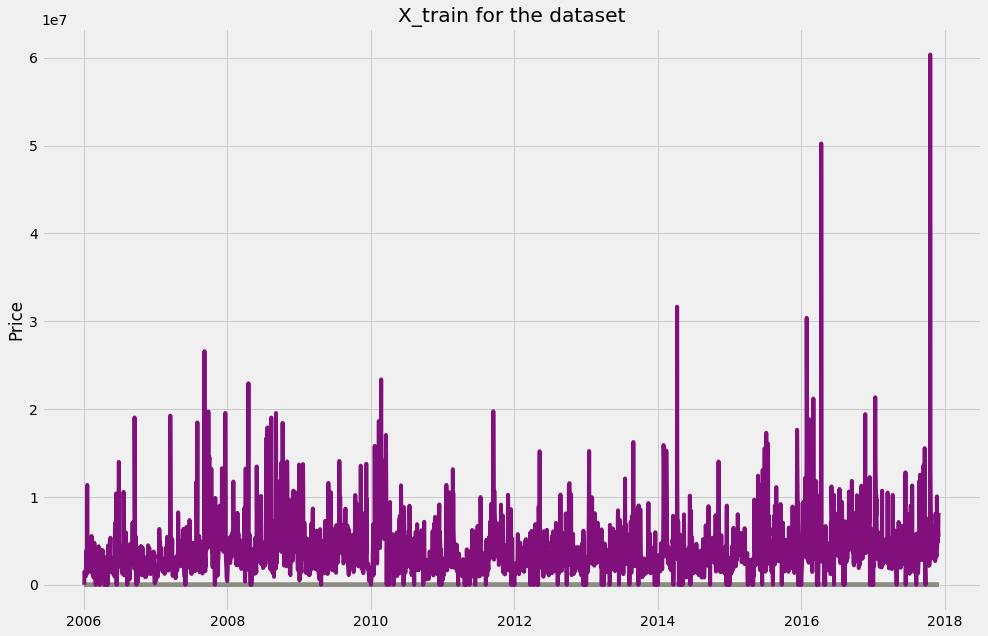

In [247]:
plt.figure(figsize=(15,10))
plt.ylabel("Price")
plt.title("X_train for the dataset")
plt.plot(train)
plt.show()

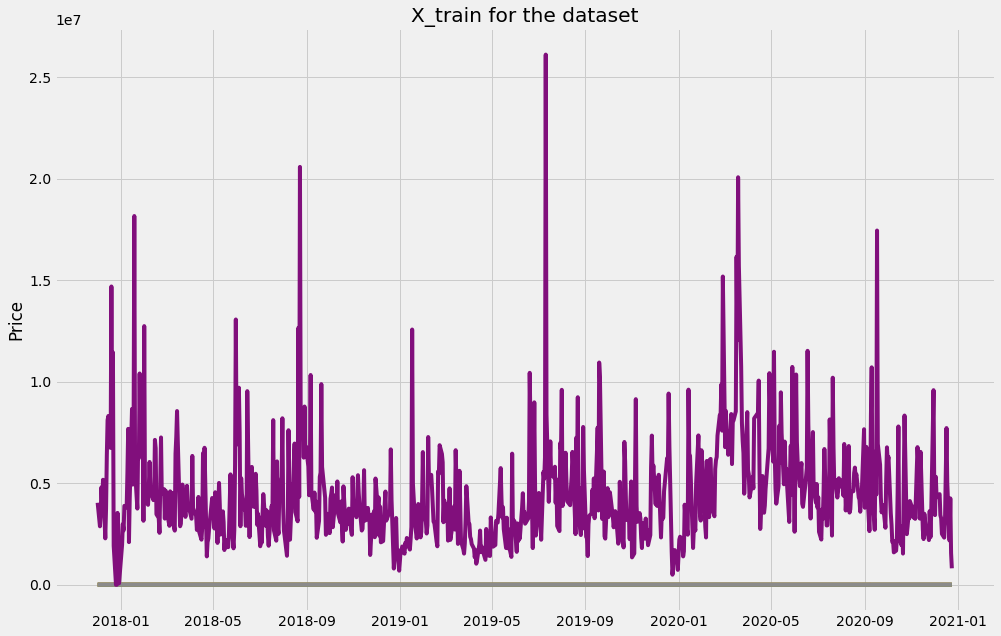

In [248]:
plt.figure(figsize=(15,10))
plt.ylabel("Price")
plt.title("X_train for the dataset")
plt.plot(test)
plt.show()

<h1>X_train,Y_train,X_test,Y_train Plot</h1>

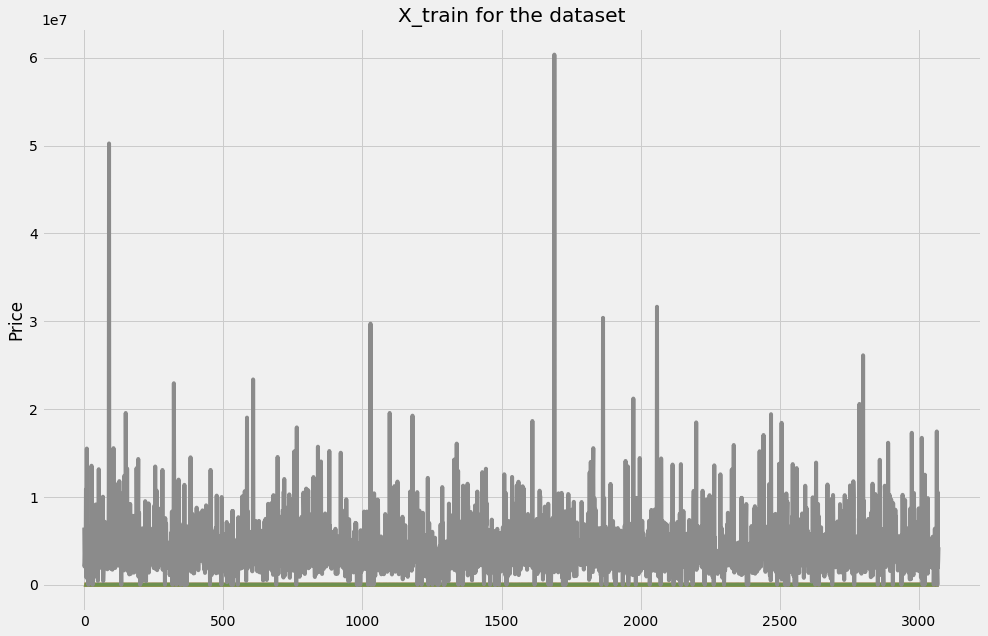

In [242]:
plt.figure(figsize=(15,10))
plt.ylabel("Price")
plt.title("X_train for the dataset")
plt.plot(train_features)
plt.show()

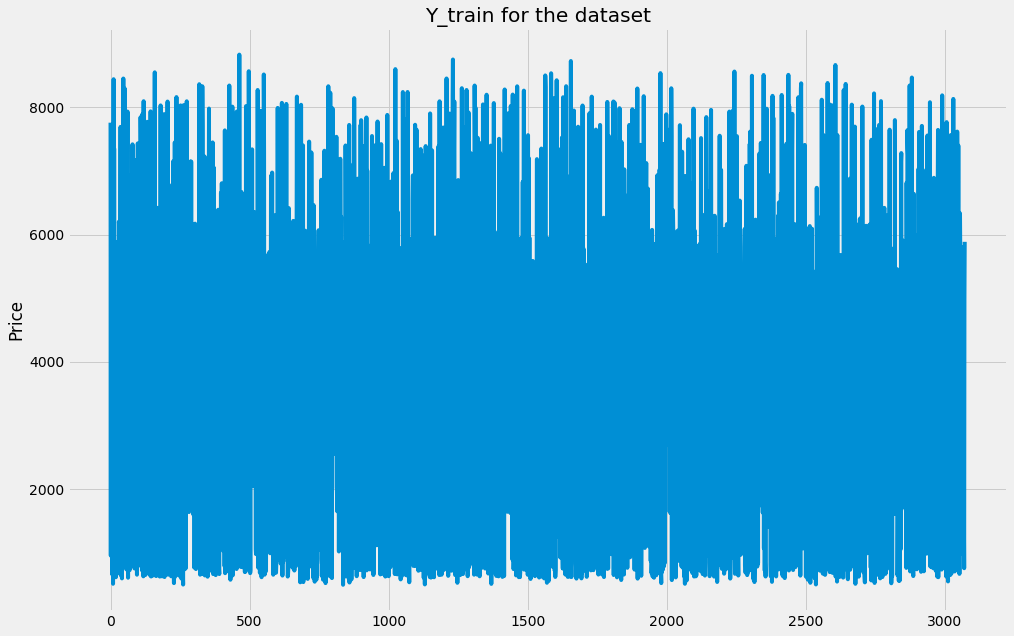

In [243]:
plt.figure(figsize=(15,10))
plt.ylabel("Price")
plt.title("Y_train for the dataset")
plt.plot(train_labels)
plt.show()

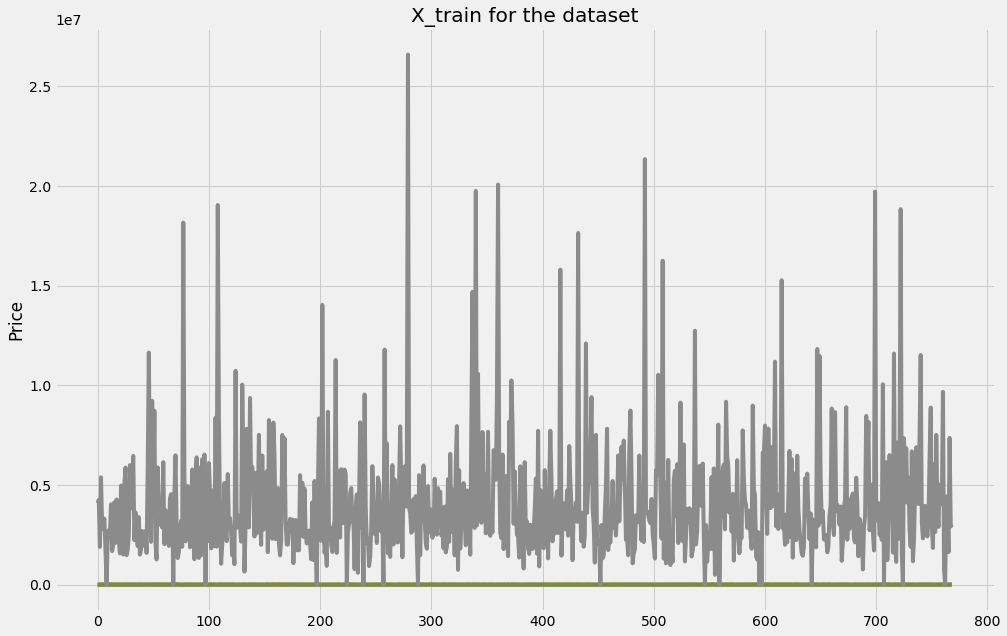

In [244]:
plt.figure(figsize=(15,10))
plt.ylabel("Price")
plt.title("X_train for the dataset")
plt.plot(test_features)
plt.show()

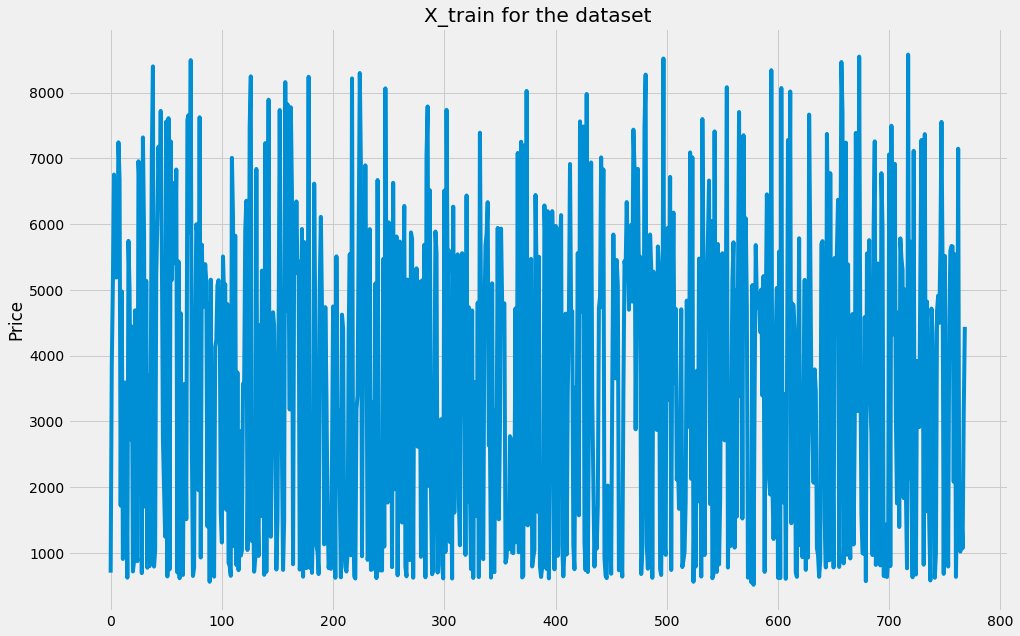

In [245]:
plt.figure(figsize=(15,10))
plt.ylabel("Price")
plt.title("X_train for the dataset")
plt.plot(test_labels)
plt.show()

<h3>Establish Baseline</h3>

Before we can make and evaluate predictions, we need to establish a baseline, a sensible measure that we hope to beat with our model. If our model cannot improve upon the baseline, then it will be a failure and we should try a different model or admit that machine learning is not right for our problem. The baseline prediction for our case can be the historical max temperature averages. In other words, our baseline is the error we would get if we simply predicted the average max temperature for all days.

In [227]:
# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('Close')]

# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)

print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  875.23


We now have our goal! If we can’t beat an average error of 875.23 degrees, then we need to rethink our approach.

<h3>Train Model</h3>


In [228]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels);

<h3>Make Predictions On The Test Set</h3>

Our model has now been trained to learn the relationships between the features and the targets.

 The next step is figuring out how good the model is! To do this we make predictions on the test features (the model is never allowed to see the test answers). 

We then compare the predictions to the known answers. When performing regression, we need to make sure to use the absolute error because we expect some of our answers to be low and some to be high.

 We are interested in how far away our average prediction is from the actual value so we take the absolute value (as we also did when establishing the baseline).

In [229]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 185.6 degrees.


Our average estimate is off by 194.87 degrees. That is more than a 680 degree average improvement over the baseline.

 Although this might not seem significant, it is nearly 22% better than the baseline, which, depending on the field and the problem, could represent millions of dollars to a company.

<h3>Determine Perfomance Metrics</h3>

To put our predictions in perspective, we can calculate an accuracy using the mean average percentage error subtracted from 100 %

In [230]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 94.02 %.


That looks pretty good! Our model has learned how to predict the maximum temperature for the next day in Seattle with 94% accuracy.

<h3>Interpret Model and Report Results</h3>

At this point, we know our model is good, but it’s pretty much a black box. We feed in some Numpy arrays for training, ask it to make a prediction, evaluate the predictions, and see that they are reasonable.

The question is: how does this model arrive at the values? There are two approaches to get under the hood of the random forest: first, we can look at a single tree in the forest, and second, we can look at the feature importances of our explanatory variables

<h3>Visualizing a single Decision Tree</h3>

We will select one tree, and save the whole tree as an image.

In [ ]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [ ]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
from subprocess import call
call(['dot', '-Tpng', 'small_tree.dot', '-o', 'tree.png', '-Gdpi=600'])
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')
'''
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');
'''

"\n(graph, ) = pydot.graph_from_dot_file('small_tree.dot')\ngraph.write_png('small_tree.png');\n"

I will condsider this section later since I am unable to display the tree


<h3> Variable importances</h3>

In order to quantify the usefulness of all the variables in the entire random forest, we can look at the relative importances of the variables. 

The importances returned in Skicit-learn represent how much including a particular variable improves the prediction.

In [231]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: High                 Importance: 0.45
Variable: Open                 Importance: 0.25
Variable: Close                Importance: 0.19
Variable: Low                  Importance: 0.1
Variable: Volume               Importance: 0.0


At the top of the list is High variable, which is the highest value of stock price for the previous day.

This tells us the best predictor of the highest closing price for the day is the High variable.

The second most important factor is the Opening price. 
The list goes on with the Low price of the stock being the least.

In future implementations of the model, we can remove those variables that have no importance and the performance will not suffer.

Additionally, if we are using a different model, say a support vector machine, we could use the random forest feature importances as a kind of feature selection method
Let’s quickly make a random forest with only the two most important variables, the max temperature 1 day prior and the historical average and see how the performance compares.


<h3> Therefore Lets Group The Model according To selected Features</h3>



<h3>(a) With all features</h3>

In [250]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 94.02 %.


<h4>(b) With The Top Four Features</h4>

In [251]:
# New random forest with only the two most important variables
rf_most_important1 = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the two most important features
important_indices1 = [feature_list.index('High'), feature_list.index('Open'),feature_list.index('Close'),feature_list.index('Low')]
train_important1 = train_features[:, important_indices1]
test_important1 = test_features[:, important_indices1]

#Train the random forest
rf_most_important1.fit(train_important1, train_labels)

# Make predictions and determine the error
predictions1 = rf_most_important1.predict(test_important1)
errors = abs(predictions1 - test_labels)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 194.85 degrees.
Accuracy: 93.6 %.


<h4>(c) With The Top Three Features</h4>

In [252]:
# New random forest with only the two most important variables
rf_most_importan2 = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the two most important features
important_indice2 = [feature_list.index('High'), feature_list.index('Open'),feature_list.index('Close')]
train_important2 = train_features[:, important_indice2]
test_important2 = test_features[:, important_indice2]

#Train the random forest
rf_most_importan2.fit(train_important2, train_labels)

# Make predictions and determine the error
predictions2 = rf_most_importan2.predict(test_important2)
errors2 = abs(predictions2 - test_labels)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors2), 2), 'degrees.')
mape = np.mean(100 * (errors2 / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')


Mean Absolute Error: 205.46 degrees.
Accuracy: 93.31 %.


<h4>(d) With The Top Two Features</h4>

In [253]:
# New random forest with only the two most important variables
rf_most_importan2 = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the two most important features
important_indice2 = [feature_list.index('High'), feature_list.index('Open')]
train_important2 = train_features[:, important_indice2]
test_important2 = test_features[:, important_indice2]

#Train the random forest
rf_most_importan2.fit(train_important2, train_labels)

# Make predictions and determine the error
predictions2 = rf_most_importan2.predict(test_important2)
errors2 = abs(predictions2 - test_labels)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors2), 2), 'degrees.')
mape = np.mean(100 * (errors2 / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')


Mean Absolute Error: 205.52 degrees.
Accuracy: 93.22 %.


<h3>With one feature</h3>

In [254]:
# New random forest with only the two most important variables
rf_most_importan2 = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the two most important features
important_indice2 = [feature_list.index('High')]
train_important2 = train_features[:, important_indice2]
test_important2 = test_features[:, important_indice2]

#Train the random forest
rf_most_importan2.fit(train_important2, train_labels)

# Make predictions and determine the error
predictions2 = rf_most_importan2.predict(test_important2)
errors2 = abs(predictions2 - test_labels)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors2), 2), 'degrees.')
mape = np.mean(100 * (errors2 / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')


Mean Absolute Error: 214.87 degrees.
Accuracy: 92.93 %.


Decreasing the number of features in the model result to a decrease in model performance. Hence, we will go with (a)

<h3>Visualizations</h3>

The first chart I’ll make is a simple bar plot of the feature importances to illustrate the disparities in the relative significance of the variables

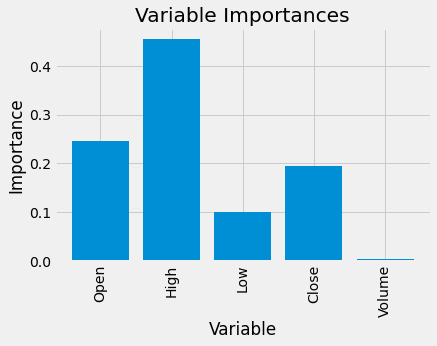

In [255]:
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Next, we can plot the entire dataset with predictions highlighted. This requires a little data manipulation, but its not too difficult. We can use this plot to determine if there are any outliers in either the data or our predictions.

In [238]:
pred_df = pd.DataFrame({'Actual': test_labels, 'Predicted': predictions})
pred_df.head()


,Actual,Predicted
0,699.735352,651.145641
1,3848.000000,3343.719256
2,5095.904297,5191.973693
3,6755.466797,6532.243381
4,5257.715820,5627.231273


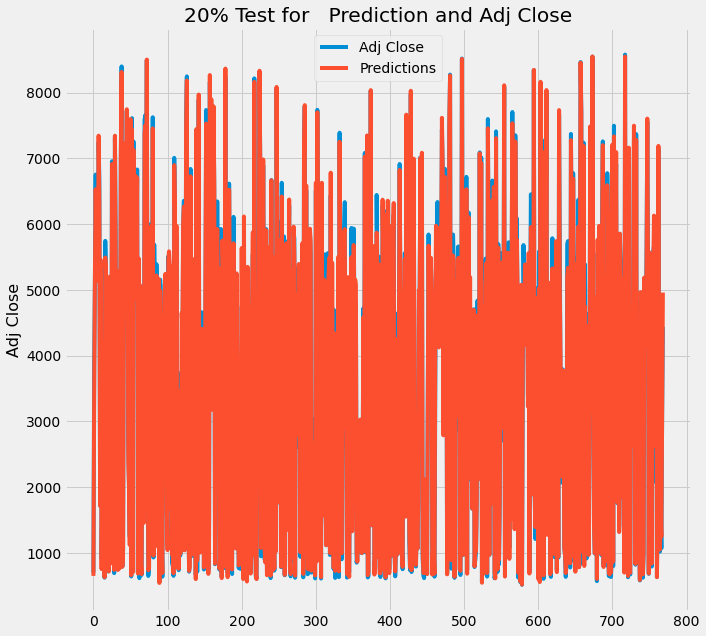

In [240]:
plt.figure(figsize=(10,10))
plt.ylabel('Adj Close', fontsize=16)
plt.title("20% Test for   Prediction and Adj Close")
plt.plot(pred_df)
plt.legend(['Adj Close', 'Predictions'])
plt.show()